In [1]:
import json
import os
import matplotlib.pyplot as plt
import pandas as pd

# Define the directory containing the JSON files
directory = "/Users/mohammadadnaan/Downloads/Prodigal_Tech/intelligent-debt-recovery-genai/data"

In [2]:
def calculate_metrics(call_data):
    """
    Calculate overtalk and silence percentages for a call.
    """
    agent_segments = []
    customer_segments = []
    
    # Separate agent and customer segments
    for utterance in call_data:
        if utterance["speaker"] == "Agent":
            agent_segments.append((utterance["stime"], utterance["etime"]))
        elif utterance["speaker"] == "Customer":
            customer_segments.append((utterance["stime"], utterance["etime"]))
    
    # Calculate total call duration
    start_time = min(agent_segments[0][0], customer_segments[0][0])
    end_time = max(agent_segments[-1][1], customer_segments[-1][1])
    total_duration = end_time - start_time
    
    # Calculate overtalk
    overtalk_duration = 0
    for agent_start, agent_end in agent_segments:
        for customer_start, customer_end in customer_segments:
            overlap_start = max(agent_start, customer_start)
            overlap_end = min(agent_end, customer_end)
            if overlap_start < overlap_end:
                overtalk_duration += overlap_end - overlap_start
    
    # Calculate silence
    all_segments = sorted(agent_segments + customer_segments, key=lambda x: x[0])
    silence_duration = 0
    previous_end = start_time
    for segment in all_segments:
        current_start, current_end = segment
        if current_start > previous_end:
            silence_duration += current_start - previous_end
        previous_end = max(previous_end, current_end)
    
    # Calculate percentages
    overtalk_percentage = (overtalk_duration / total_duration) * 100
    silence_percentage = (silence_duration / total_duration) * 100
    
    return overtalk_percentage, silence_percentage


In [3]:
def process_call_files(directory):
    """
    Process all call files in the directory and return aggregated metrics.
    """
    if not os.path.exists(directory):
        print(f"Directory '{directory}' does not exist.")
        return
    
    # Initialize lists to store results
    call_ids = []
    overtalk_percentages = []
    silence_percentages = []
    
    for filename in os.listdir(directory):
        if filename.endswith(".json"):
            filepath = os.path.join(directory, filename)
            try:
                with open(filepath, 'r') as file:
                    call_data = json.load(file)
                    call_id = filename.split('.')[0]
                    overtalk_percentage, silence_percentage = calculate_metrics(call_data)
                    
                    # Append results to lists
                    call_ids.append(call_id)
                    overtalk_percentages.append(overtalk_percentage)
                    silence_percentages.append(silence_percentage)
                    
            except json.JSONDecodeError:
                print(f"Error decoding JSON in file: {filename}")
            except KeyError as e:
                print(f"Missing key {e} in file: {filename}")
            except Exception as e:
                print(f"An error occurred while processing file {filename}: {e}")
    
    # Create a DataFrame to store the results
    results_df = pd.DataFrame({
        'Call ID': call_ids,
        'Overtalk Percentage': overtalk_percentages,
        'Silence Percentage': silence_percentages
    })
    
    return results_df

In [5]:
# Process all files and get the results
results_df = process_call_files(directory)
# Display the first few rows of the results
print(results_df.head())

An error occurred while processing file 0ba31ba1-24ab-4d20-b0f2-eee6bc9a3d42.json: list index out of range
                                Call ID  Overtalk Percentage  \
0  2db2965e-54fa-41fa-823b-ed79b943f0b1            16.000000   
1  8a9655a7-be88-4921-b0ad-04aa1b9953d1             6.315789   
2  19169ec6-213f-48e9-8ec2-c24ee2e6eb20            11.538462   
3  c86714f0-3aeb-4628-8cfa-ee0a46839508             9.411765   
4  0c8297aa-ced1-414e-a175-bf29a9763d30             7.954545   

   Silence Percentage  
0            1.000000  
1            8.421053  
2            4.807692  
3            8.235294  
4            7.954545  


In [6]:
# Aggregate metrics for the entire dataset
average_overtalk = results_df['Overtalk Percentage'].mean()
average_silence = results_df['Silence Percentage'].mean()

print(f"Average Overtalk Percentage: {average_overtalk:.2f}%")
print(f"Average Silence Percentage: {average_silence:.2f}%")

Average Overtalk Percentage: 10.39%
Average Silence Percentage: 4.36%


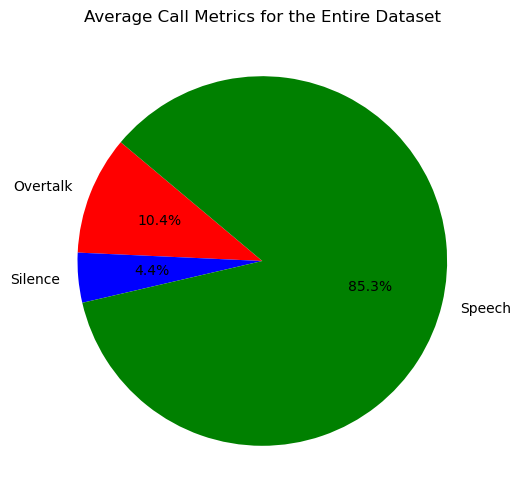

In [7]:
# Visualize the aggregated metrics
labels = ['Overtalk', 'Silence', 'Speech']
sizes = [average_overtalk, average_silence, 100 - average_overtalk - average_silence]
colors = ['red', 'blue', 'green']

plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Average Call Metrics for the Entire Dataset')
plt.show()

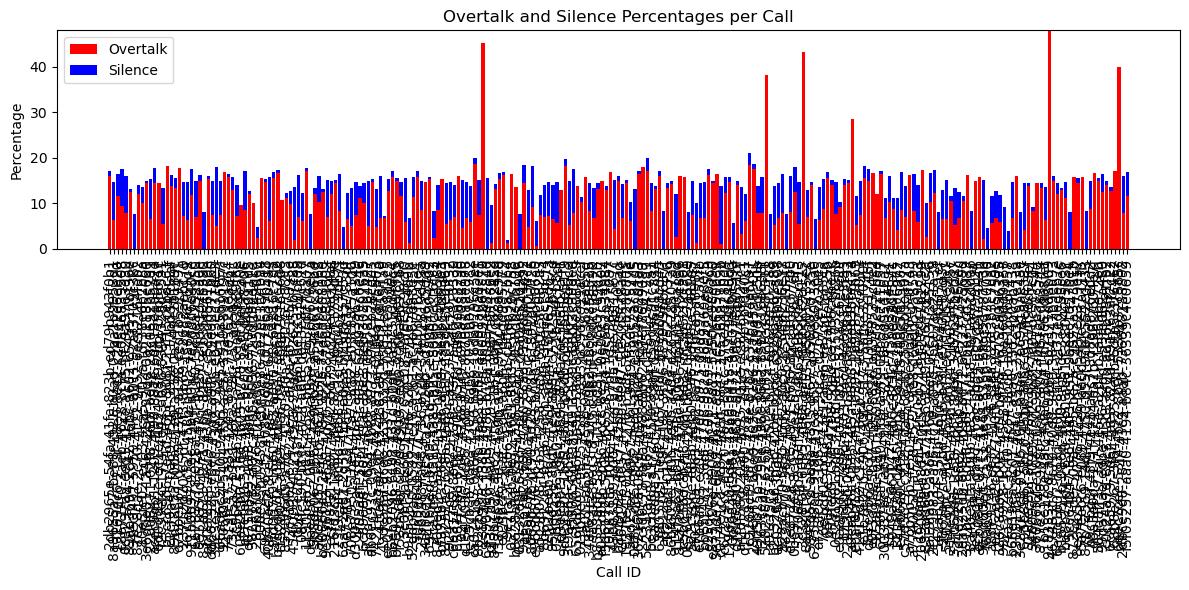

In [8]:
plt.figure(figsize=(12, 6))
plt.bar(results_df['Call ID'], results_df['Overtalk Percentage'], color='red', label='Overtalk')
plt.bar(results_df['Call ID'], results_df['Silence Percentage'], color='blue', label='Silence', bottom=results_df['Overtalk Percentage'])
plt.xlabel('Call ID')
plt.ylabel('Percentage')
plt.title('Overtalk and Silence Percentages per Call')
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.show()